<a href="https://colab.research.google.com/github/Codamaze/OilSpillDetection/blob/main/Deeplabv3%2Bmobilenetv3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


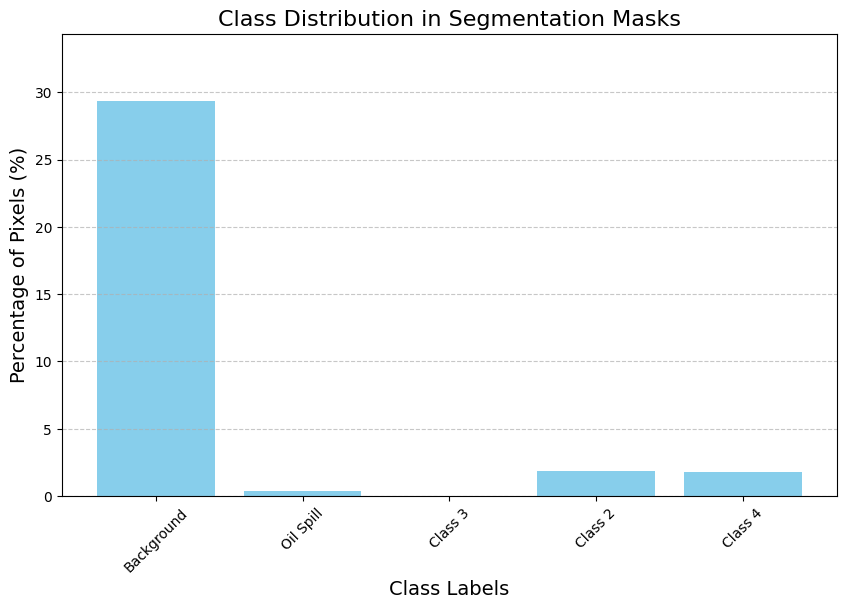

Class Weights and Colors:
Class Background: Weight = 0.6817533399695173, Color = (0, 0, 0)
Class Oil Spill: Weight = 59.802326854172144, Color = (0, 255, 255)
Class Class 3: Weight = 1389.3699889323523, Color = (153, 76, 0)
Class Class 2: Weight = 10.620097447870142, Color = (255, 0, 0)
Class Class 4: Weight = 11.330430207719271, Color = (0, 153, 0)


In [ ]:
import os
import numpy as np
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt

# Define the path to your dataset
mask_dir = "/content/drive/MyDrive/oil-spill/train/labels"  # Update this with the folder containing segmentation masks

# Define the RGB values for each class
class_colors = {
    'Background': (0, 0, 0),
    'Oil Spill': (0, 255, 255),
    'Class 2': (255, 0, 0),
    'Class 3': (153, 76, 0),
    'Class 4': (0, 153, 0)
}

# Initialize counters and total pixel count
class_counts = defaultdict(int)
total_pixels = 0

# Convert class_colors to a list of RGB tuples and class names
color_list = list(class_colors.values())
class_names = list(class_colors.keys())

# Iterate through the mask files
for mask_file in os.listdir(mask_dir):
    mask_path = os.path.join(mask_dir, mask_file)

    # Load the mask image
    mask = np.array(Image.open(mask_path))  # Assuming masks are stored as RGB images (e.g., PNG)

    # Reshape mask to (H*W, 3) for vectorized comparison
    mask_reshaped = mask.reshape(-1, 3)

    # Convert the color mapping to a NumPy array for efficient broadcasting
    color_array = np.array(color_list, dtype=np.uint8)

    # Compare the reshaped mask with the color array and find matching indices
    matches = np.all(mask_reshaped[:, None, :] == color_array, axis=2)

    # Get the indices of the matching colors using argmax and convert to class names
    match_indices = np.argmax(matches, axis=1)
    matched_classes = np.array(class_names)[match_indices]

    # Count the occurrences of each class using NumPy
    unique_classes, counts = np.unique(matched_classes, return_counts=True)

    # Update the class counts from the current mask
    for cls, count in zip(unique_classes, counts):
        class_counts[cls] += count

    total_pixels += mask.size  # Count total pixels in the mask


# Calculate class weights based on pixel counts
class_weights = {}
for class_name, count in class_counts.items():
    weight = total_pixels / (len(class_colors) * count)  # Inverse frequency-based weight
    class_weights[class_name] = weight

# Prepare data for visualization
classes = list(class_counts.keys())
counts = [class_counts[class_name] for class_name in classes]
percentages = [count / total_pixels * 100 for count in counts]

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(classes, percentages, color='skyblue')
plt.xlabel("Class Labels", fontsize=14)
plt.ylabel("Percentage of Pixels (%)", fontsize=14)
plt.title("Class Distribution in Segmentation Masks", fontsize=16)
plt.xticks(rotation=45)
plt.ylim(0, max(percentages) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print the class weights and corresponding colors
print("Class Weights and Colors:")
for class_name, weight in class_weights.items():
    color = class_colors.get(class_name, "Unknown")
    print(f"Class {class_name}: Weight = {weight}, Color = {color}")

In [ ]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset
from albumentations import Compose, RandomCrop, HorizontalFlip, Rotate, GaussNoise, RandomBrightnessContrast, HueSaturationValue
from albumentations.pytorch import ToTensorV2
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define color-to-class mapping (RGB values for each class)
COLOR_MAP = [
    [0, 0, 0],        # Class 0: Black
    [0, 255, 255],    # Class 1: Cyan
    [153, 76, 0],      # Class 2: Brown
    [255, 0, 0],     # Class 3: Red
    [0, 153, 0],      # Class 4: Green
]

def process_mask(rgb_mask, colormap):
    """
    Converts an RGB mask to a one-hot encoded class mask using the provided colormap.
    Args:
        rgb_mask: RGB mask (H, W, 3)
        colormap: List of RGB values for each class.
    Returns:
        One-hot encoded mask (H, W, num_classes)
    """
    output_mask = []
    for i, color in enumerate(colormap):
        cmap = np.all(np.equal(rgb_mask, color), axis=-1).astype(np.uint8)  # Check if pixel matches color and cast to uint8
        output_mask.append(cmap)

    output_mask = np.stack(output_mask, axis=-1)  # Stack the individual class masks to create a one-hot mask
    return output_mask

# Define the augmentation pipeline
transform = Compose([
    RandomCrop(height=256, width=256),             # Random cropping
    HorizontalFlip(p=0.5),                         # Horizontal flipping
    Rotate(limit=30, p=0.5),                       # Random rotation
    HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.4),  # Adjust colors slightly
    RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  # Mild adjustments
    ToTensorV2(),                      # Convert to PyTorch tensors
])

# Dataset class
class MultiClassOilSpillDataset(Dataset):
    def __init__(self, image_dir, mask_dir, color_mapping, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(image_dir)
        self.color_mapping = color_mapping
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Read unchanged for SAR images

        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", ".png"))
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  # Ensure RGB format

        ''' to apply visulaisation
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title("Raw Image")

        plt.subplot(1, 2, 2)
        plt.imshow(mask_rgb)
        plt.title("Raw Mask")

        plt.show()'''

        # Load image and mask
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Load SAR image as is
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)      # Load mask as RGB

        # Validate data
        if image is None or mask is None:
            raise FileNotFoundError(f"Missing file: {img_path} or {mask_path}")

        # Normalize SAR image dynamically
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = image.astype(np.float32) # Cast the image to float32


        # Resize image and mask
        image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Convert mask to class indices
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        processed_mask = process_mask(mask, self.color_mapping)

        # Apply augmentations if specified
        if self.transform:
            augmented = self.transform(image=image, mask=processed_mask)
            image = augmented['image']
            mask = augmented['mask']

            image = np.clip(image, 0, 1)

        return image, mask



/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


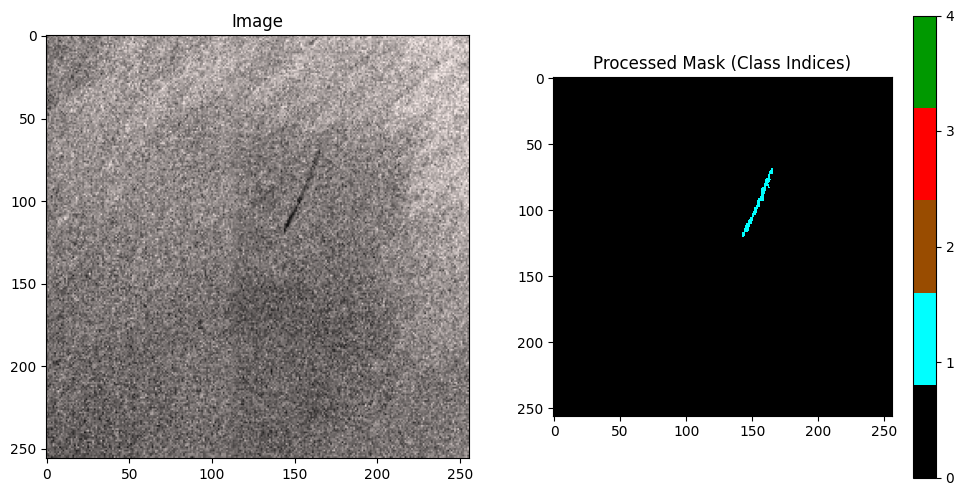

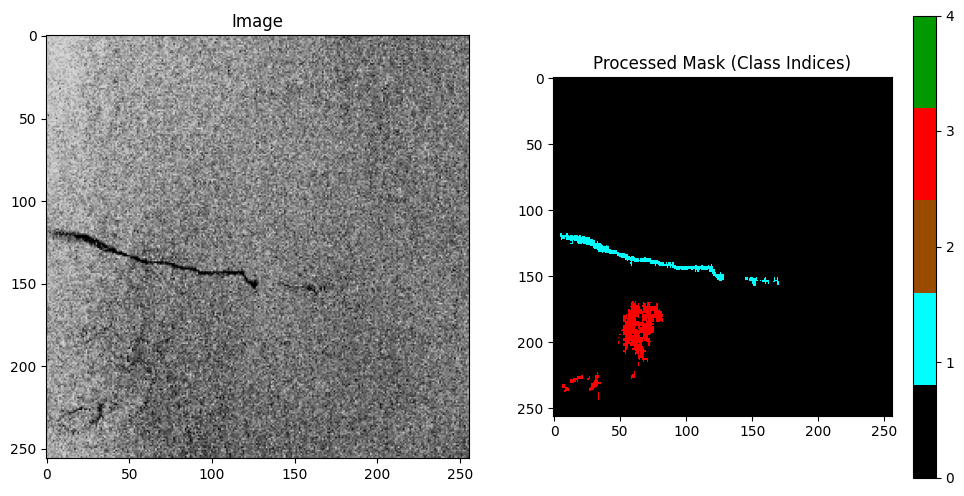

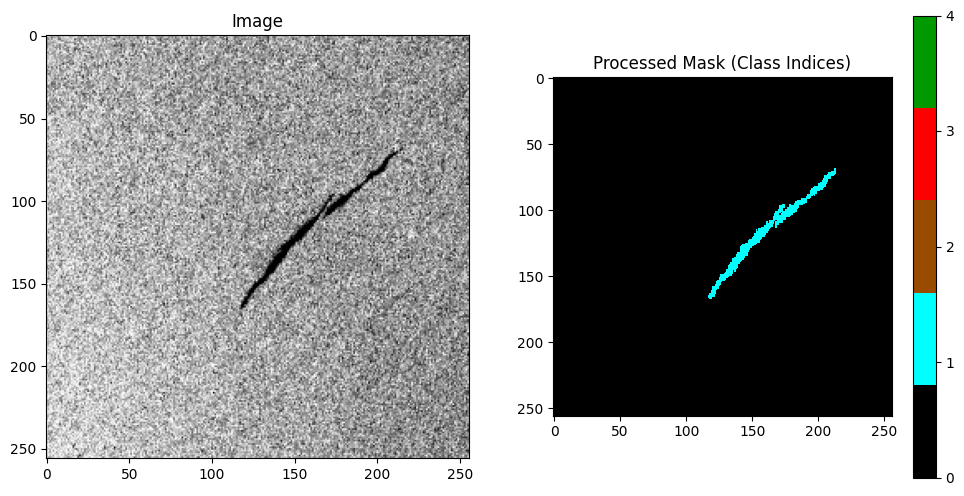

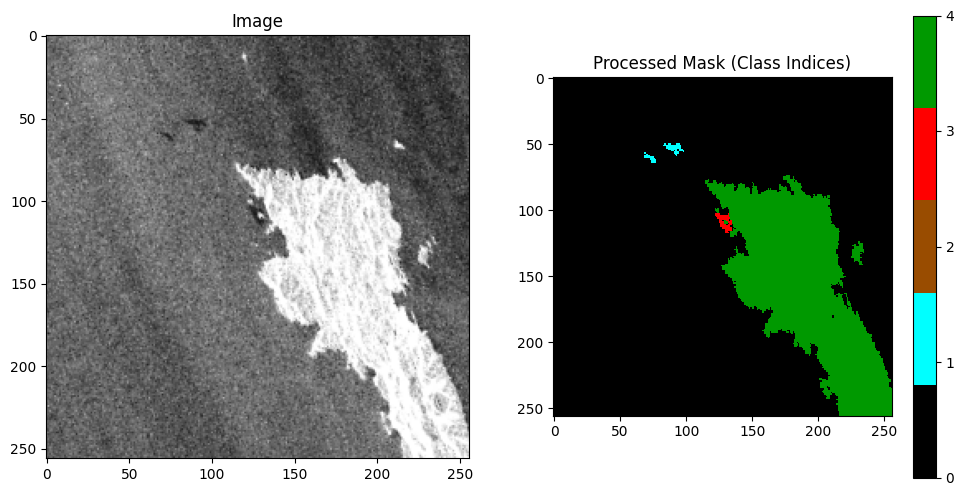

In [ ]:
# Visualize the dataset
def visualize_dataset(dataset, num_images_to_plot=5):
    # Define the color map for the classes
    scaled_color_map = [[c[0] / 255.0, c[1] / 255.0, c[2] / 255.0] for c in COLOR_MAP]
    cmap = mcolors.ListedColormap(scaled_color_map)

    for i in range(num_images_to_plot):
        image, mask = dataset[i]

        # Convert image back to (H, W, C) for plotting, and denormalize the image for display
        image = image.permute(1, 2, 0).numpy() * 255  # Rescale to [0, 255]
        image = np.clip(image, 0, 255).astype(np.uint8)  # Ensure valid range

        # Get the class indices from the one-hot encoded mask
        mask_class_indices = np.argmax(mask, axis=-1)

        # Plot the image and corresponding mask
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(image)  # Display the image
        plt.title("Image")

        plt.subplot(1, 2, 2)
        plt.imshow(mask_class_indices, cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
        plt.colorbar(ticks=range(len(COLOR_MAP)))
        plt.title("Processed Mask (Class Indices)")

        plt.show()

# Define paths for your dataset (update with actual paths)
train_image_dir = '/content/drive/MyDrive/oil-spill/train/images'
train_mask_dir = '/content/drive/MyDrive/oil-spill/train/labels'


# Create the dataset
train_dataset = MultiClassOilSpillDataset(train_image_dir, train_mask_dir, COLOR_MAP, transform)

# Visualize some images and their masks
visualize_dataset(train_dataset, num_images_to_plot=4)

In [ ]:
#Calculation dice coeffcient for loss
import torch.nn as nn
def dice_loss(pred, target, smooth=1):
    pred = torch.softmax(pred, dim=1)  # Apply softmax to predictions
    target_one_hot = torch.eye(pred.shape[1], device=pred.device)[target].permute(0, 3, 1, 2).to(pred.device)
    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

#to use combination of dice coefficient and CrossEntropyloss
class CombinedLoss(nn.Module):
    def __init__(self, class_weights):
        super(CombinedLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, pred, target):
        ce_loss = self.cross_entropy(pred, target)
        d_loss = dice_loss(pred, target)
        return ce_loss + d_loss


In [ ]:
# Functions to compute mean IOU and accuracy
def compute_iou(pred, target, num_classes):
    pred = torch.argmax(pred, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        if union == 0:
            ious.append(0.0)  # Perfect IoU for empty class
        else:
            ious.append(intersection / (union + 1e-8))
    return np.mean(ious)

def compute_accuracy(pred, target):
    """
    Computes the accuracy of the predictions.

    Args:
        pred: Predicted logits from the model (N, C, H, W).
        target: Ground truth class indices (N, H, W).

    Returns:
        Accuracy as a float.
    """
    pred_classes = torch.argmax(pred, dim=1)
    correct = (pred_classes == target).sum().float()
    total = target.numel()
    return (correct / total).item()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_large
from torchvision.models.mobilenetv3 import MobileNet_V3_Large_Weights

# Atrous Spatial Pyramid Pooling (ASPP) module
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.gn1 = nn.GroupNorm(16, out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, dilation=1, bias=False)
        self.gn2 = nn.GroupNorm(16, out_channels)

        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=6, padding=6, bias=False)
        self.gn3= nn.GroupNorm(16, out_channels)

        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=12, padding=12, bias=False)
        self.gn4= nn.GroupNorm(16, out_channels)

        self.conv5 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=18, padding=18, bias=False)
        self.gn5= nn.GroupNorm(16, out_channels)

        self.output = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1, bias=False)
        self.out_gn= nn.GroupNorm(16, out_channels)

    def forward(self, x):
        h, w = x.size(2), x.size(3)

        y1 = self.avg_pool(x)
        y1 = self.conv1(y1)
        y1 = self.gn1(y1)
        y1 = self.relu(y1)
        y1 = F.interpolate(y1, size=(h, w), mode="bilinear", align_corners=False)

        y2 = self.conv2(x)
        y2 = self.gn2(y2)
        y2 = self.relu(y2)

        y3 = self.conv3(x)
        y3 = self.gn3(y3)
        y3 = self.relu(y3)

        y4 = self.conv4(x)
        y4 = self.gn4(y4)
        y4 = self.relu(y4)

        y5 = self.conv5(x)
        y5 = self.gn5(y5)
        y5 = self.relu(y5)

        y = torch.cat([y1, y2, y3, y4, y5], dim=1)
        y = self.output(y)
        y = self.out_gn(y)
        return self.relu(y)


# DeepLabV3+ module
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3Plus, self).__init__()
        self.encoder = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT).features

        # Extract intermediate layers
        self.low_level_idx = 3  # Low-level features from MobileNetV3
        self.high_level_idx = 16  # High-level features from MobileNetV3

        self.aspp = ASPP(in_channels=160, out_channels=256) # 160 channels for MobileNetV3 model
        # Low-level feature projection
        self.low_level_conv = nn.Conv2d(24, 48, kernel_size=1, bias=False)
        self.low_level_gn = nn.GroupNorm(16, 48)
        self.low_level_relu = nn.ReLU()

        # Decoder
        self.concat_conv1 = nn.Conv2d(256 + 48, 256, kernel_size=3, padding=1, bias=False)
        self.concat_gn1 = nn.GroupNorm(32, 256)
        self.concat_relu1 = nn.ReLU()

        self.concat_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False)
        self.concat_gn2= nn.GroupNorm(32, 256)
        self.concat_relu2 = nn.ReLU()

        self.final_conv = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        h, w = x.size(2), x.size(3)

        # Encoder
        low_level_features = self.encoder[:self.low_level_idx](x)
        high_level_features = self.encoder[:self.high_level_idx](x)

        # ASPP
        x = self.aspp(high_level_features)
        x = F.interpolate(x, size=(h // 4, w // 4), mode="bilinear", align_corners=False)

        # Low-level features
        low_level_features = self.low_level_conv(low_level_features)
        low_level_features = self.low_level_gn(low_level_features)
        low_level_features = self.low_level_relu(low_level_features)

        # Concatenate low-level and ASPP features
        x = torch.cat([x, low_level_features], dim=1)

        # Decoder
        x = self.concat_conv1(x)
        x = self.concat_gn1(x)
        x = self.concat_relu1(x)

        x = self.concat_conv2(x)
        x = self.concat_gn2(x)
        x = self.concat_relu2(x)

        # Upsample to original size
        x = F.interpolate(x, size=(h, w), mode="bilinear", align_corners=False)

        # Final classification layer
        x = self.final_conv(x)
        return x




In [ ]:
if __name__ == "__main__":
    # Initialize the model with the number of output classes
    model = DeepLabV3Plus(num_classes=5)  # 5 classes for segmentation

    # Create a random input tensor with the shape [batch_size, channels, height, width]
    x = torch.randn(1, 3, 256, 256)  # Example input (batch size 1, RGB image, 256x256)

    # Pass the input through the model
    output = model(x)

    # Print the output shape
    print(f"Output shape: {output.shape}")


Output shape: torch.Size([1, 5, 256, 256])


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim

def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-3 ):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    # Example class weights (modify according to your dataset)
    class_weights = torch.tensor([0.6817533399695173, 59.802326854172144 , 1389.3699889323523, 10.620097447870142, 11.330430207719271 ]).to(device)

    # Assuming `CombinedLoss` is defined elsewhere
    criterion = CombinedLoss(class_weights)  # Modify this to match your loss class
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    best_val_iou = float('inf')
    epochs_without_improvement = 0

    metrics = {
        "train_loss": [],
        "val_loss": [],
        "train_iou": [],
        "val_iou": [],
        "train_accuracy": [],
        "val_accuracy": []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training Phase
        model.train()
        train_loss = 0
        train_iou = 0
        train_accuracy=0
        train_progress = tqdm(train_loader, desc="Training", unit="batch")
        for images, masks in train_progress:
            images, masks = images.to(device), masks.to(device)

            # Permute one-hot encoded masks to (N, C, H, W)
            masks = masks.permute(0, 3, 1, 2)  # From (N, H, W, C) to (N, C, H, W)

            # Get the model's output
            outputs = model(images)

            # Resize the masks to match the model's output size dynamically
            masks_resized = F.interpolate(masks.float(), size=outputs.shape[2:], mode='nearest')

            # Convert masks from one-hot encoding to class indices for the loss function
            masks_resized = torch.argmax(masks_resized, dim=1).long()  # Shape: (N, H, W)

            optimizer.zero_grad()
            loss = criterion(outputs, masks_resized)  # Loss expects class indices, not one-hot encoding

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Gradient clipping
            optimizer.step()

            train_loss += loss.item()
            train_iou += compute_iou(outputs, masks_resized, num_classes=5)
            train_accuracy += compute_accuracy(outputs, masks_resized)
            train_progress.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        avg_train_iou = train_iou / len(train_loader)
        avg_train_accuracy = train_accuracy / len(train_loader)
        metrics["train_loss"].append(avg_train_loss)
        metrics["train_iou"].append(avg_train_iou)
        metrics["train_accuracy"].append(avg_train_accuracy)
        print(f"Training Loss: {avg_train_loss:.4f}, Training IoU: {avg_train_iou:.4f}, Training Accuracy: {avg_train_accuracy:.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0
        val_iou = 0
        val_accuracy=0
        val_progress = tqdm(val_loader, desc="Validation", unit="batch")
        with torch.no_grad():
            for images, masks in val_progress:
                images, masks = images.to(device), masks.to(device)

                # Permute one-hot encoded masks to (N, C, H, W)
                masks = masks.permute(0, 3, 1, 2)  # From (N, H, W, C) to (N, C, H, W)

                # Get the model's output
                outputs = model(images)

                # Resize the masks to match the model's output size dynamically
                masks_resized = F.interpolate(masks.float(), size=outputs.shape[2:], mode='nearest')

                # Convert masks from one-hot encoding to class indices for the loss function
                masks_resized = torch.argmax(masks_resized, dim=1).long()  # Shape: (N, H, W)

                loss = criterion(outputs, masks_resized)  # Loss expects class indices, not one-hot encoding

                val_loss += loss.item()
                val_accuracy += compute_accuracy(outputs, masks_resized)
                val_iou += compute_iou(outputs, masks_resized, num_classes=5)
                val_progress.set_postfix(loss=loss.item())

        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        metrics["val_loss"].append(avg_val_loss)
        metrics["val_iou"].append(avg_val_iou)
        metrics["val_accuracy"].append(avg_val_accuracy)
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation IoU: {avg_val_iou:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")

        scheduler.step(avg_val_loss)

        ''' Early Stopping
        if avg_val_iou < best_val_iou:
            best_val_iou = avg_val_iou
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model_unet.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered.")
                break'''

        # Save the model after training is complete
        save_path = 'Deeplabv3+_50.pth'
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

    return metrics


In [ ]:
from torch.utils.data import DataLoader, random_split

# Paths to dataset
image_dir = "/content/drive/MyDrive/oil-spill/train/images"
mask_dir = "/content/drive/MyDrive/oil-spill/train/labels"

dataset = MultiClassOilSpillDataset(image_dir, mask_dir, COLOR_MAP, transform=transform)

# Split dataset
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Initialize models
num_classes = len(COLOR_MAP)  # Number of classes
deeplabv3plus_model = DeepLabV3Plus(num_classes=5)

# Train Deeplabv3
print("Training DeepLabV3Plus...")
train_metrics = train_model(deeplabv3plus_model, train_loader, val_loader, num_epochs=50, lr=1e-3)

Training DeepLabV3Plus...
Epoch 1/50


Training: 100%|██████████| 57/57 [05:42<00:00,  6.01s/batch, loss=1.86]


Training Loss: 1.9058, Training IoU: 0.2488, Training Accuracy: 0.6495


Validation: 100%|██████████| 7/7 [00:51<00:00,  7.40s/batch, loss=2.16]


Validation Loss: 2.1000, Validation IoU: 0.2182, Validation Accuracy: 0.8004
Model saved to Deeplabv3+_50.pth
Epoch 2/50


Training: 100%|██████████| 57/57 [01:01<00:00,  1.08s/batch, loss=1.01]


Training Loss: 1.2904, Training IoU: 0.3871, Training Accuracy: 0.8143


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.13s/batch, loss=1.72]


Validation Loss: 1.6480, Validation IoU: 0.2484, Validation Accuracy: 0.8487
Model saved to Deeplabv3+_50.pth
Epoch 3/50


Training: 100%|██████████| 57/57 [01:02<00:00,  1.10s/batch, loss=1.19]


Training Loss: 1.1450, Training IoU: 0.4182, Training Accuracy: 0.8423


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.17batch/s, loss=1.17]


Validation Loss: 1.3975, Validation IoU: 0.3556, Validation Accuracy: 0.8898
Model saved to Deeplabv3+_50.pth
Epoch 4/50


Training: 100%|██████████| 57/57 [01:02<00:00,  1.09s/batch, loss=1.32]


Training Loss: 1.2021, Training IoU: 0.4103, Training Accuracy: 0.8483


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.18batch/s, loss=1.55]


Validation Loss: 1.2996, Validation IoU: 0.3243, Validation Accuracy: 0.8334
Model saved to Deeplabv3+_50.pth
Epoch 5/50


Training: 100%|██████████| 57/57 [01:02<00:00,  1.09s/batch, loss=1.12]


Training Loss: 1.1884, Training IoU: 0.3961, Training Accuracy: 0.8353


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.02s/batch, loss=1.23]


Validation Loss: 1.3412, Validation IoU: 0.3320, Validation Accuracy: 0.7828
Model saved to Deeplabv3+_50.pth
Epoch 6/50


Training: 100%|██████████| 57/57 [01:00<00:00,  1.06s/batch, loss=1.72]


Training Loss: 1.0749, Training IoU: 0.4348, Training Accuracy: 0.8635


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.24s/batch, loss=0.962]


Validation Loss: 1.0578, Validation IoU: 0.4374, Validation Accuracy: 0.8961
Model saved to Deeplabv3+_50.pth
Epoch 7/50


Training: 100%|██████████| 57/57 [00:59<00:00,  1.04s/batch, loss=0.985]


Training Loss: 1.0542, Training IoU: 0.4282, Training Accuracy: 0.8493


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.15s/batch, loss=1.07]


Validation Loss: 1.2029, Validation IoU: 0.4470, Validation Accuracy: 0.8625
Model saved to Deeplabv3+_50.pth
Epoch 8/50


Training: 100%|██████████| 57/57 [01:00<00:00,  1.07s/batch, loss=0.807]


Training Loss: 1.0708, Training IoU: 0.4506, Training Accuracy: 0.8664


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.17batch/s, loss=0.994]


Validation Loss: 1.0822, Validation IoU: 0.4509, Validation Accuracy: 0.8852
Model saved to Deeplabv3+_50.pth
Epoch 9/50


Training: 100%|██████████| 57/57 [01:01<00:00,  1.09s/batch, loss=0.837]


Training Loss: 0.9639, Training IoU: 0.4715, Training Accuracy: 0.8855


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.19batch/s, loss=0.899]


Validation Loss: 1.0292, Validation IoU: 0.4420, Validation Accuracy: 0.8528
Model saved to Deeplabv3+_50.pth
Epoch 10/50


Training: 100%|██████████| 57/57 [01:01<00:00,  1.08s/batch, loss=0.815]


Training Loss: 0.9339, Training IoU: 0.4882, Training Accuracy: 0.8914


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.16batch/s, loss=0.947]


Validation Loss: 1.0394, Validation IoU: 0.5048, Validation Accuracy: 0.9373
Model saved to Deeplabv3+_50.pth
Epoch 11/50


Training: 100%|██████████| 57/57 [01:18<00:00,  1.37s/batch, loss=0.81]


Training Loss: 1.0124, Training IoU: 0.4562, Training Accuracy: 0.8770


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.01s/batch, loss=0.749]


Validation Loss: 0.9326, Validation IoU: 0.4331, Validation Accuracy: 0.9045
Model saved to Deeplabv3+_50.pth
Epoch 12/50


Training: 100%|██████████| 57/57 [01:01<00:00,  1.07s/batch, loss=1.15]


Training Loss: 0.8685, Training IoU: 0.4745, Training Accuracy: 0.8827


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.24s/batch, loss=1.26]


Validation Loss: 0.9791, Validation IoU: 0.4302, Validation Accuracy: 0.8446
Model saved to Deeplabv3+_50.pth
Epoch 13/50


Training: 100%|██████████| 57/57 [01:00<00:00,  1.06s/batch, loss=1.1]


Training Loss: 0.9111, Training IoU: 0.4725, Training Accuracy: 0.8856


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.13s/batch, loss=0.852]


Validation Loss: 0.9274, Validation IoU: 0.3981, Validation Accuracy: 0.8305
Model saved to Deeplabv3+_50.pth
Epoch 14/50


Training: 100%|██████████| 57/57 [01:03<00:00,  1.11s/batch, loss=1.25]


Training Loss: 0.8018, Training IoU: 0.4850, Training Accuracy: 0.8964


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.19batch/s, loss=0.799]


Validation Loss: 0.8395, Validation IoU: 0.4597, Validation Accuracy: 0.8764
Model saved to Deeplabv3+_50.pth
Epoch 15/50


Training: 100%|██████████| 57/57 [01:02<00:00,  1.10s/batch, loss=1.06]


Training Loss: 0.8802, Training IoU: 0.4651, Training Accuracy: 0.8884


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.16batch/s, loss=0.877]


Validation Loss: 0.8940, Validation IoU: 0.4230, Validation Accuracy: 0.8758
Model saved to Deeplabv3+_50.pth
Epoch 16/50


Training: 100%|██████████| 57/57 [01:02<00:00,  1.09s/batch, loss=0.689]


Training Loss: 0.7982, Training IoU: 0.4891, Training Accuracy: 0.8975


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.03batch/s, loss=0.694]


Validation Loss: 0.8142, Validation IoU: 0.4642, Validation Accuracy: 0.9095
Model saved to Deeplabv3+_50.pth
Epoch 17/50


Training: 100%|██████████| 57/57 [01:01<00:00,  1.09s/batch, loss=0.745]


Training Loss: 0.7522, Training IoU: 0.5026, Training Accuracy: 0.9062


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.23s/batch, loss=0.671]


Validation Loss: 0.8312, Validation IoU: 0.4853, Validation Accuracy: 0.9338
Model saved to Deeplabv3+_50.pth
Epoch 18/50


Training: 100%|██████████| 57/57 [01:00<00:00,  1.06s/batch, loss=1.13]


Training Loss: 0.7980, Training IoU: 0.4858, Training Accuracy: 0.8934


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.05s/batch, loss=0.663]


Validation Loss: 0.8606, Validation IoU: 0.4366, Validation Accuracy: 0.9027
Model saved to Deeplabv3+_50.pth
Epoch 19/50


Training: 100%|██████████| 57/57 [01:02<00:00,  1.09s/batch, loss=0.82]


Training Loss: 0.7870, Training IoU: 0.4854, Training Accuracy: 0.8943


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.14batch/s, loss=1.01]


Validation Loss: 0.8740, Validation IoU: 0.4447, Validation Accuracy: 0.8547
Model saved to Deeplabv3+_50.pth
Epoch 20/50


Training: 100%|██████████| 57/57 [01:03<00:00,  1.11s/batch, loss=0.768]


Training Loss: 0.7786, Training IoU: 0.4924, Training Accuracy: 0.8999


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.16batch/s, loss=1.01]


Validation Loss: 1.0793, Validation IoU: 0.4101, Validation Accuracy: 0.8227
Model saved to Deeplabv3+_50.pth
Epoch 21/50


Training: 100%|██████████| 57/57 [01:02<00:00,  1.09s/batch, loss=0.669]


Training Loss: 0.7417, Training IoU: 0.5082, Training Accuracy: 0.9062


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.02s/batch, loss=0.732]


Validation Loss: 0.8065, Validation IoU: 0.4641, Validation Accuracy: 0.8806
Model saved to Deeplabv3+_50.pth
Epoch 22/50


Training: 100%|██████████| 57/57 [01:00<00:00,  1.06s/batch, loss=0.904]


Training Loss: 0.7229, Training IoU: 0.5146, Training Accuracy: 0.9123


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.21s/batch, loss=0.704]


Validation Loss: 0.8159, Validation IoU: 0.4755, Validation Accuracy: 0.8942
Model saved to Deeplabv3+_50.pth
Epoch 23/50


Training: 100%|██████████| 57/57 [01:00<00:00,  1.05s/batch, loss=0.682]


Training Loss: 0.7137, Training IoU: 0.5213, Training Accuracy: 0.9152


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.12s/batch, loss=0.684]


Validation Loss: 0.7766, Validation IoU: 0.4858, Validation Accuracy: 0.8997
Model saved to Deeplabv3+_50.pth
Epoch 24/50


Training: 100%|██████████| 57/57 [01:01<00:00,  1.08s/batch, loss=0.874]


Training Loss: 0.7161, Training IoU: 0.5064, Training Accuracy: 0.9091


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.16batch/s, loss=0.788]


Validation Loss: 0.8142, Validation IoU: 0.4683, Validation Accuracy: 0.8692
Model saved to Deeplabv3+_50.pth
Epoch 25/50


Training: 100%|██████████| 57/57 [01:02<00:00,  1.09s/batch, loss=0.636]


Training Loss: 0.6934, Training IoU: 0.5206, Training Accuracy: 0.9125


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.19batch/s, loss=0.598]


Validation Loss: 0.7565, Validation IoU: 0.4809, Validation Accuracy: 0.9176
Model saved to Deeplabv3+_50.pth
Epoch 26/50


Training: 100%|██████████| 57/57 [01:01<00:00,  1.08s/batch, loss=0.822]


Training Loss: 0.6967, Training IoU: 0.5073, Training Accuracy: 0.9103


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.19batch/s, loss=0.641]


Validation Loss: 0.8904, Validation IoU: 0.4997, Validation Accuracy: 0.9187
Model saved to Deeplabv3+_50.pth
Epoch 27/50


Training: 100%|██████████| 57/57 [01:01<00:00,  1.08s/batch, loss=0.868]


Training Loss: 0.7504, Training IoU: 0.4913, Training Accuracy: 0.8985


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.10s/batch, loss=0.632]


Validation Loss: 0.7640, Validation IoU: 0.4933, Validation Accuracy: 0.8950
Model saved to Deeplabv3+_50.pth
Epoch 28/50


Training: 100%|██████████| 57/57 [00:59<00:00,  1.05s/batch, loss=0.56]


Training Loss: 0.7304, Training IoU: 0.4945, Training Accuracy: 0.8908


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.26s/batch, loss=0.67]


Validation Loss: 0.7730, Validation IoU: 0.4240, Validation Accuracy: 0.8947
Model saved to Deeplabv3+_50.pth
Epoch 29/50


Training: 100%|██████████| 57/57 [01:01<00:00,  1.07s/batch, loss=0.633]


Training Loss: 0.7188, Training IoU: 0.5010, Training Accuracy: 0.8961


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.15batch/s, loss=0.626]


Validation Loss: 0.7561, Validation IoU: 0.4959, Validation Accuracy: 0.9313
Model saved to Deeplabv3+_50.pth
Epoch 30/50


Training: 100%|██████████| 57/57 [01:01<00:00,  1.07s/batch, loss=1.06]


Training Loss: 0.6783, Training IoU: 0.5206, Training Accuracy: 0.9140


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.19batch/s, loss=0.571]


Validation Loss: 0.7454, Validation IoU: 0.4784, Validation Accuracy: 0.9103
Model saved to Deeplabv3+_50.pth
Epoch 31/50


Training: 100%|██████████| 57/57 [01:02<00:00,  1.09s/batch, loss=0.572]


Training Loss: 0.7424, Training IoU: 0.5122, Training Accuracy: 0.9074


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.02batch/s, loss=0.647]


Validation Loss: 0.7634, Validation IoU: 0.4997, Validation Accuracy: 0.9095
Model saved to Deeplabv3+_50.pth
Epoch 32/50


Training: 100%|██████████| 57/57 [01:00<00:00,  1.06s/batch, loss=0.756]


Training Loss: 0.6810, Training IoU: 0.5050, Training Accuracy: 0.9116


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.21s/batch, loss=0.722]


Validation Loss: 0.9290, Validation IoU: 0.4737, Validation Accuracy: 0.9139
Model saved to Deeplabv3+_50.pth
Epoch 33/50


Training: 100%|██████████| 57/57 [00:59<00:00,  1.05s/batch, loss=0.586]


Training Loss: 0.6937, Training IoU: 0.5125, Training Accuracy: 0.9131


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.16s/batch, loss=0.662]


Validation Loss: 0.8147, Validation IoU: 0.4979, Validation Accuracy: 0.9030
Model saved to Deeplabv3+_50.pth
Epoch 34/50


Training: 100%|██████████| 57/57 [01:01<00:00,  1.09s/batch, loss=0.616]


Training Loss: 0.6466, Training IoU: 0.5199, Training Accuracy: 0.9135


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.18batch/s, loss=0.744]


Validation Loss: 0.8106, Validation IoU: 0.4474, Validation Accuracy: 0.8525
Model saved to Deeplabv3+_50.pth
Epoch 35/50


Training: 100%|██████████| 57/57 [01:02<00:00,  1.10s/batch, loss=0.691]


Training Loss: 0.6472, Training IoU: 0.5266, Training Accuracy: 0.9125


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.16batch/s, loss=0.593]


Validation Loss: 0.7826, Validation IoU: 0.4879, Validation Accuracy: 0.8837
Model saved to Deeplabv3+_50.pth
Epoch 36/50


Training: 100%|██████████| 57/57 [01:02<00:00,  1.10s/batch, loss=0.57]


Training Loss: 0.6510, Training IoU: 0.5240, Training Accuracy: 0.9143


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.05s/batch, loss=0.581]


Validation Loss: 0.9070, Validation IoU: 0.4374, Validation Accuracy: 0.8665
Model saved to Deeplabv3+_50.pth
Epoch 37/50


Training: 100%|██████████| 57/57 [01:00<00:00,  1.06s/batch, loss=0.691]


Training Loss: 0.6042, Training IoU: 0.5435, Training Accuracy: 0.9232


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.25s/batch, loss=0.634]


Validation Loss: 0.7177, Validation IoU: 0.4789, Validation Accuracy: 0.8888
Model saved to Deeplabv3+_50.pth
Epoch 38/50


Training: 100%|██████████| 57/57 [01:00<00:00,  1.06s/batch, loss=1.12]


Training Loss: 0.5916, Training IoU: 0.5310, Training Accuracy: 0.9188


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.08s/batch, loss=0.474]


Validation Loss: 0.7304, Validation IoU: 0.5316, Validation Accuracy: 0.9310
Model saved to Deeplabv3+_50.pth
Epoch 39/50


Training: 100%|██████████| 57/57 [01:01<00:00,  1.08s/batch, loss=0.53]


Training Loss: 0.5538, Training IoU: 0.5458, Training Accuracy: 0.9295


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.18batch/s, loss=0.5]


Validation Loss: 0.7184, Validation IoU: 0.5073, Validation Accuracy: 0.9073
Model saved to Deeplabv3+_50.pth
Epoch 40/50


Training: 100%|██████████| 57/57 [01:02<00:00,  1.09s/batch, loss=0.437]


Training Loss: 0.5236, Training IoU: 0.5526, Training Accuracy: 0.9317


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.15batch/s, loss=0.38]


Validation Loss: 0.6915, Validation IoU: 0.5354, Validation Accuracy: 0.9329
Model saved to Deeplabv3+_50.pth
Epoch 41/50


Training: 100%|██████████| 57/57 [01:02<00:00,  1.09s/batch, loss=0.56]


Training Loss: 0.5563, Training IoU: 0.5425, Training Accuracy: 0.9268


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.01batch/s, loss=0.397]


Validation Loss: 0.7268, Validation IoU: 0.5314, Validation Accuracy: 0.9267
Model saved to Deeplabv3+_50.pth
Epoch 42/50


Training: 100%|██████████| 57/57 [01:00<00:00,  1.07s/batch, loss=0.563]


Training Loss: 0.5257, Training IoU: 0.5525, Training Accuracy: 0.9283


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.23s/batch, loss=0.491]


Validation Loss: 0.7281, Validation IoU: 0.5361, Validation Accuracy: 0.9361
Model saved to Deeplabv3+_50.pth
Epoch 43/50


Training: 100%|██████████| 57/57 [00:59<00:00,  1.05s/batch, loss=0.523]


Training Loss: 0.5064, Training IoU: 0.5549, Training Accuracy: 0.9365


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.16s/batch, loss=0.484]


Validation Loss: 0.6631, Validation IoU: 0.5108, Validation Accuracy: 0.9148
Model saved to Deeplabv3+_50.pth
Epoch 44/50


Training: 100%|██████████| 57/57 [01:00<00:00,  1.07s/batch, loss=0.537]


Training Loss: 0.5162, Training IoU: 0.5576, Training Accuracy: 0.9313


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.16batch/s, loss=0.412]


Validation Loss: 0.6467, Validation IoU: 0.5352, Validation Accuracy: 0.9297
Model saved to Deeplabv3+_50.pth
Epoch 45/50


Training: 100%|██████████| 57/57 [01:02<00:00,  1.09s/batch, loss=0.492]


Training Loss: 0.4883, Training IoU: 0.5691, Training Accuracy: 0.9384


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.17batch/s, loss=0.396]


Validation Loss: 0.6935, Validation IoU: 0.5199, Validation Accuracy: 0.9311
Model saved to Deeplabv3+_50.pth
Epoch 46/50


Training: 100%|██████████| 57/57 [01:01<00:00,  1.09s/batch, loss=0.537]


Training Loss: 0.4916, Training IoU: 0.5574, Training Accuracy: 0.9356


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.18batch/s, loss=0.384]


Validation Loss: 0.7210, Validation IoU: 0.5200, Validation Accuracy: 0.9140
Model saved to Deeplabv3+_50.pth
Epoch 47/50


Training: 100%|██████████| 57/57 [01:02<00:00,  1.09s/batch, loss=0.5]


Training Loss: 0.4864, Training IoU: 0.5571, Training Accuracy: 0.9311


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.14s/batch, loss=0.391]


Validation Loss: 0.7000, Validation IoU: 0.5490, Validation Accuracy: 0.9248
Model saved to Deeplabv3+_50.pth
Epoch 48/50


Training: 100%|██████████| 57/57 [01:00<00:00,  1.06s/batch, loss=0.415]


Training Loss: 0.4847, Training IoU: 0.5623, Training Accuracy: 0.9357


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.13s/batch, loss=0.333]


Validation Loss: 0.6079, Validation IoU: 0.5426, Validation Accuracy: 0.9311
Model saved to Deeplabv3+_50.pth
Epoch 49/50


Training: 100%|██████████| 57/57 [01:01<00:00,  1.08s/batch, loss=0.51]


Training Loss: 0.4674, Training IoU: 0.5620, Training Accuracy: 0.9349


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.14batch/s, loss=0.348]


Validation Loss: 0.6889, Validation IoU: 0.5373, Validation Accuracy: 0.9262
Model saved to Deeplabv3+_50.pth
Epoch 50/50


Training: 100%|██████████| 57/57 [01:01<00:00,  1.08s/batch, loss=0.542]


Training Loss: 0.4479, Training IoU: 0.5653, Training Accuracy: 0.9366


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.16batch/s, loss=0.345]


Validation Loss: 0.6609, Validation IoU: 0.5421, Validation Accuracy: 0.9248
Model saved to Deeplabv3+_50.pth


In [ ]:
# After training the model
torch.save(deeplabv3plus_model.state_dict(), 'deeplabv3+_mobilentv3_50.pth')


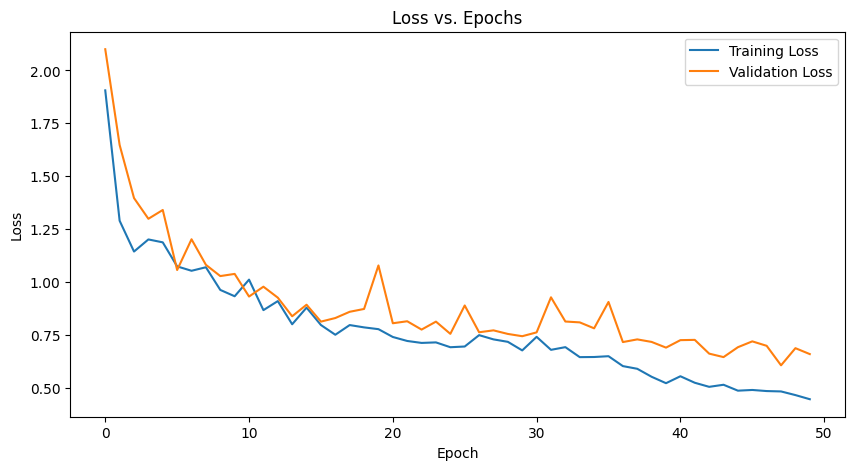

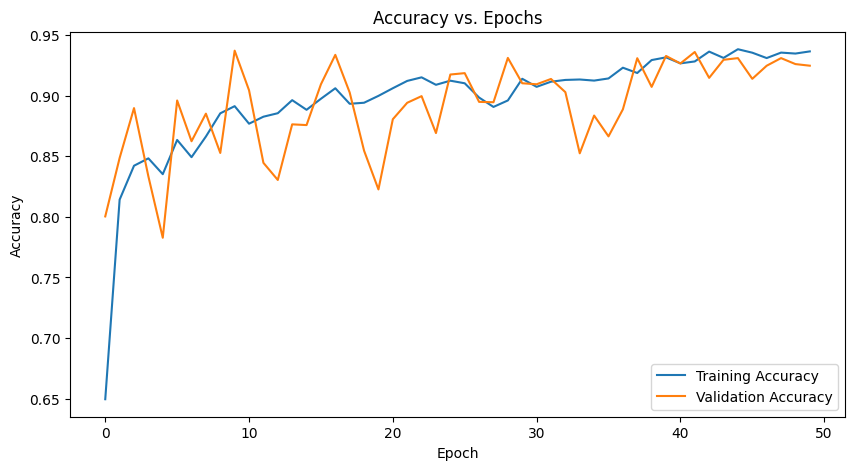

In [ ]:
import matplotlib.pyplot as plt
# Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(train_metrics["train_loss"], label="Training Loss")
plt.plot(train_metrics["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epochs")
plt.show()

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(train_metrics["train_accuracy"], label="Training Accuracy")
plt.plot(train_metrics["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs. Epochs")
plt.show()


In [ ]:
model = DeepLabV3Plus(num_classes=5)
model.load_state_dict(torch.load('deeplabv3+_mobilentv3_50.pth'))
model.eval()  # Set the model to evaluation mode

<ipython-input-21-438491394167>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('deeplabv3+_mobilentv3_50.pth'))


DeepLabV3Plus(
  (encoder): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), b

In [ ]:
!pip install torchsummary

import torch
from torchsummary import summary

model = DeepLabV3Plus(num_classes=5)
model.load_state_dict(torch.load('deeplabv3+_mobilentv3_50.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Get the appropriate device
model.to(device)
model.eval()
summary(model, input_size=(3, 256, 256))

<ipython-input-23-819001d5f06b>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('deeplabv3+_mobilentv3_50.pth'))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             432
       BatchNorm2d-2         [-1, 16, 128, 128]              32
         Hardswish-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]             144
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             256
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 64, 128, 128]           1,024
      BatchNorm2d-11         [-1, 64, 128, 128]             128
             ReLU-12         [-1, 64, 128, 128]               0
           Conv2d-13           [-1, 64, 64, 64]             576
      BatchNorm2d-14           [-1, 64,